In [1]:
import os
import platform  

# Codice utile a Cristian per cambiare il path in base al sistema operativo e utilizzare GPU/MPS a seconda del caso
if platform.uname().node == "PC-Cristian":
    device = "cuda"
    main_folder = "G:\\Il mio Drive/Magistrale/Secondo Semestre/ML/PythonNotebooks/PW"
elif platform.uname().node == "MacBook-Pro-di-Cristian.local":
    device = "mps"
    main_folder = "/Users/cristian/Library/CloudStorage/GoogleDrive-c.cerasuolo2@studenti.unisa.it/Il mio Drive/Magistrale/Secondo Semestre/ML/PythonNotebooks/PW"
else:
    pass

In [2]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device(device)

In [4]:
!pip install validators

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=b8c17a29591d46ff606d99fea89f58431b71a1d4b1f7fcdd8b91db562de97c28
  Stored in directory: /Users/cristian/Library/Caches/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [10]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b4', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)


Using cache found in /Users/cristian/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /Users/cristian/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=48, out_features=12, bias=True)
          (expand): Linear(in_features=12, out_features=48, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
    

In [12]:
# Fine tune the model, substituting the last layer with a new one in order to do a binary classification
efficientnet.classifier.fc = torch.nn.Linear(1792, 1).to(device)

efficientnet

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=48, out_features=12, bias=True)
          (expand): Linear(in_features=12, out_features=48, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
    

In [6]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

In [7]:
with torch.no_grad():
    output = torch.nn.functional.softmax(efficientnet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('library', '55.5%'), ('desk', '42.1%'), ('laptop, laptop computer', '0.7%'), ('monitor', '0.3%'), ('mouse, computer mouse', '0.2%')]
sample 1: [('mashed potato', '57.9%'), ('meat loaf, meatloaf', '17.8%'), ('broccoli', '15.8%'), ('plate', '7.2%'), ('potpie', '0.1%')]
sample 2: [('racket, racquet', '97.7%'), ('tennis ball', '2.0%'), ('ping-pong ball', '0.1%'), ('volleyball', '0.0%'), ('basketball', '0.0%')]
sample 3: [('kelpie', '66.9%'), ('schipperke', '13.9%'), ('Labrador retriever', '2.9%'), ('Italian greyhound', '2.1%'), ('groenendael', '2.0%')]


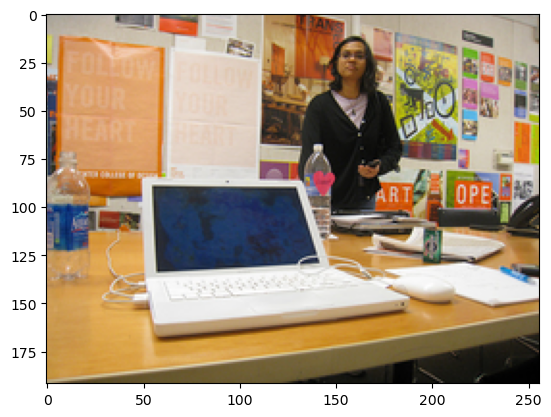

[('library', '55.5%'), ('desk', '42.1%'), ('laptop, laptop computer', '0.7%'), ('monitor', '0.3%'), ('mouse, computer mouse', '0.2%')]


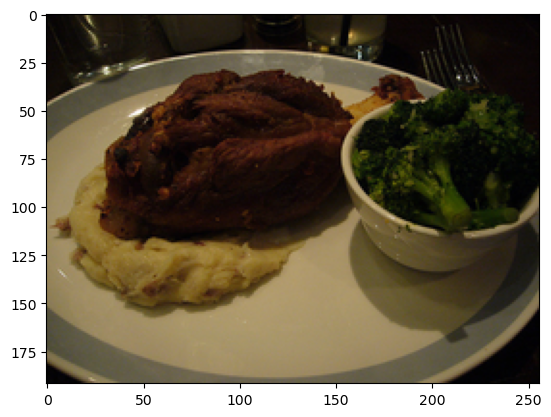

[('mashed potato', '57.9%'), ('meat loaf, meatloaf', '17.8%'), ('broccoli', '15.8%'), ('plate', '7.2%'), ('potpie', '0.1%')]


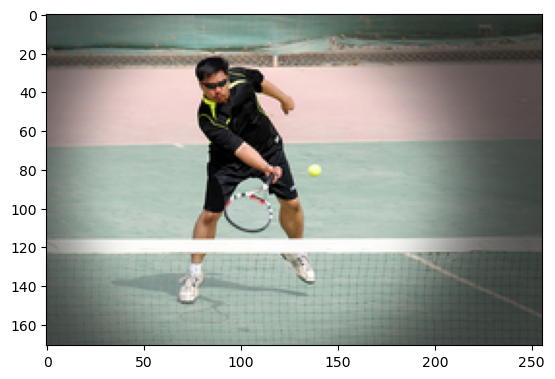

[('racket, racquet', '97.7%'), ('tennis ball', '2.0%'), ('ping-pong ball', '0.1%'), ('volleyball', '0.0%'), ('basketball', '0.0%')]


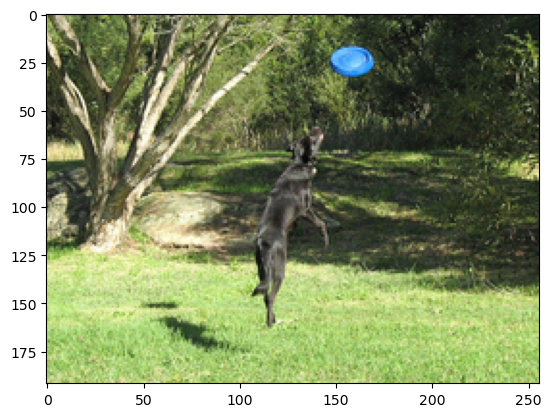

[('kelpie', '66.9%'), ('schipperke', '13.9%'), ('Labrador retriever', '2.9%'), ('Italian greyhound', '2.1%'), ('groenendael', '2.0%')]


In [8]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.imshow(img)
    plt.show()
    print(result)